# Fase de pré-processamento

- Entrada: arquivo exportado pelo scraper da UOL
- Saída: Arquivo estruturado pronto para submissão ao modelo de aprendizagem

In [1]:
import sys

sys.path.append('..')

from hyperparameters.TeamStrength import *
from itertools import compress

from enum import Enum
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

plt.style.use('seaborn')

%matplotlib inline

In [2]:
# Carga do arquivo de saída do scraper
file_src = '../output/br-league.json'

with open(file_src) as f:
    raw_data = json.load(f)

class Seasons(Enum):
    FIRST = 45
    SECOND = 90
    
def getEventsInfo(events, team, season):
    filtered = [(event["team"] == team and int(event["time"]) <= season.value) for event in events]
    return filtered.count(True)

def addTacticalType(s, data, i, is_home):
    prefix = 'h' if is_home else 'a'
    if (s == 'OFF'):
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 1
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 0
    elif (s == 'DEF'):
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 1
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 0
    else:
        data["{}_substitution_{}_tactical_type_off".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_def".format(prefix, i)] = 0
        data["{}_substitution_{}_tactical_type_na".format(prefix, i)] = 1

def addInterval(t, data, i, is_home):
    prefix = 'h' if is_home else 'a'
    if (t >= 0 and t <= 30):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
    elif (t > 30 and t <= 60):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 1
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 0
    elif (t > 60 and t <= 90):
        data["{}_substitution_{}_interval_0".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_1".format(prefix, i)] = 0
        data["{}_substitution_{}_interval_2".format(prefix, i)] = 1

def getYearFromDate(date):
    return date[:4]

def getSubsInfoAndLabelsHome(data, substitutions):
    MAX_SUBSTITUTIONS = 3
    
    # Home substitutions:
    s = [subs["team"] == data["home_team_name"] for subs in substitutions]
    d = list(compress(substitutions, s))

    for i in range(MAX_SUBSTITUTIONS):
        try:
            data["h_substitution_{}_score_away".format(i)] = d[i]["score_away"]
            data["h_substitution_{}_score_home".format(i)] = d[i]["score_home"]
            data["h_substitution_{}_time".format(i)] = 45 if d[i]["time"] == 'INTERVALO' else d[i]["time"]
            data["h_substitution_{}_number".format(i)] = d[i]["number_of_sub"]
            data["h_substitution_{}_is_home".format(i)] = 1 if d[i]["team"] == data["home_team_name"] else 0
            addInterval(int(d[i]["time"]), data, i, data["h_substitution_{}_is_home".format(i)])
            addTacticalType(d[i]["tactical_type"], data, i, data["h_substitution_{}_is_home".format(i)])
            data["y_{}_effectiveness".format(i)] = d[i]["effectiveness"]
            if (data["h_substitution_{}_interval_1".format(i)] == None):
                break
        except:
            data["h_substitution_{}_score_away".format(i)] = 0
            data["h_substitution_{}_score_home".format(i)] = 0
            data["h_substitution_{}_time".format(i)] = 0
            data["h_substitution_{}_number".format(i)] = 0
            data["h_substitution_{}_is_home".format(i)] = 0
            data["y_{}_effectiveness".format(i)] = 0
            data["h_substitution_{}_interval_0".format(i)] = 0
            data["h_substitution_{}_interval_1".format(i)] = 0
            data["h_substitution_{}_interval_2".format(i)] = 0
            data["h_substitution_{}_tactical_type_off".format(i)] = 0
            data["h_substitution_{}_tactical_type_def".format(i)] = 0
            data["h_substitution_{}_tactical_type_na".format(i)] = 0
            
def getSubsInfoAndLabelsAway(data, substitutions):
    MAX_SUBSTITUTIONS = 3
    
    # Home substitutions:
    s = [subs["team"] != data["home_team_name"] for subs in substitutions]
    d = list(compress(substitutions, s))

    for i in range(MAX_SUBSTITUTIONS):
        try:
            data["a_substitution_{}_score_away".format(i)] = d[i]["score_away"]
            data["a_substitution_{}_score_home".format(i)] = d[i]["score_home"]
            data["a_substitution_{}_time".format(i)] = 45 if d[i]["time"] == 'INTERVALO' else d[i]["time"]
            data["a_substitution_{}_number".format(i)] = d[i]["number_of_sub"]
            data["a_substitution_{}_is_home".format(i)] = 1 if d[i]["team"] == data["home_team_name"] else 0
            addInterval(int(d[i]["time"]), data, i, data["a_substitution_{}_is_home".format(i)])
            addTacticalType(d[i]["tactical_type"], data, i, data["a_substitution_{}_is_home".format(i)])
            data["y_{}_effectiveness".format(i)] = d[i]["effectiveness"]
            if (data["a_substitution_{}_interval_1".format(i)] == None):
                break
        except:
            data["a_substitution_{}_score_away".format(i)] = 0
            data["a_substitution_{}_score_home".format(i)] = 0
            data["a_substitution_{}_time".format(i)] = 0
            data["a_substitution_{}_number".format(i)] = 0
            data["a_substitution_{}_is_home".format(i)] = 0
            data["y_{}_effectiveness".format(i)] = 0
            data["a_substitution_{}_interval_0".format(i)] = 0
            data["a_substitution_{}_interval_1".format(i)] = 0
            data["a_substitution_{}_interval_2".format(i)] = 0
            data["a_substitution_{}_tactical_type_off".format(i)] = 0
            data["a_substitution_{}_tactical_type_def".format(i)] = 0
            data["a_substitution_{}_tactical_type_na".format(i)] = 0
            
def dataFormatter(raw_data):
    output = []
    for d in raw_data:
        data = {}
        data["date"] = d["date"]
        data["home_team_name"] = d["home"]
        data["away_team_name"] = d["away"]
        data["home_win"] = d["home_win"]
        data["HG"] = d["HG"]
        data["AG"] = d["AG"]
        data["PH"] = d["PH"]
        data["PD"] = d["PD"]
        data["PA"] = d["PA"]
        data["MaxH"] = d["MaxH"]
        data["MaxD"] = d["MaxD"]
        data["MaxA"] = d["MaxA"]
        data["AvgH"] = d["AvgH"]
        data["AvgD"] = d["AvgD"]
        data["AvgA"] = d["AvgA"]
        data["away_team_strength"] = TeamStrength().buildParam(d["away"], getYearFromDate(d["date"]))
        data["home_team_strength"] = TeamStrength().buildParam(d["home"], getYearFromDate(d["date"]))
        data["ycards_home_1st_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.FIRST)
        data["ycards_away_1st_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.FIRST)
        data["ycards_home_2nd_season"] = getEventsInfo(d["yellowcards"],  d["home"], Seasons.SECOND)
        data["ycards_away_2nd_season"] = getEventsInfo(d["yellowcards"],  d["away"], Seasons.SECOND)
        data["rcards_home_1st_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.FIRST)
        data["rcards_away_1st_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.FIRST)
        data["rcards_home_2nd_season"] = getEventsInfo(d["redcards"],     d["home"], Seasons.SECOND)
        data["rcards_away_2nd_season"] = getEventsInfo(d["redcards"],     d["away"], Seasons.SECOND)
        data["agoals_home_1st_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.FIRST)
        data["agoals_away_1st_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.FIRST)
        data["agoals_home_2nd_season"] = getEventsInfo(d["againstgoals"], d["home"], Seasons.SECOND)
        data["agoals_away_2nd_season"] = getEventsInfo(d["againstgoals"], d["away"], Seasons.SECOND)
        data["penaltys_home_1st_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.FIRST)
        data["penaltys_away_1st_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.FIRST)
        data["penaltys_home_2nd_season"] = getEventsInfo(d["penaltys"],   d["home"], Seasons.SECOND)
        data["penaltys_away_2nd_season"] = getEventsInfo(d["penaltys"],   d["away"], Seasons.SECOND)
        getSubsInfoAndLabelsHome(data, d["substitutions"])
        getSubsInfoAndLabelsAway(data, d["substitutions"])
        output.append(data)
    return output
    
data = dataFormatter(raw_data)
json_stringify = json.dumps(data)
df = pd.read_json(json_stringify)

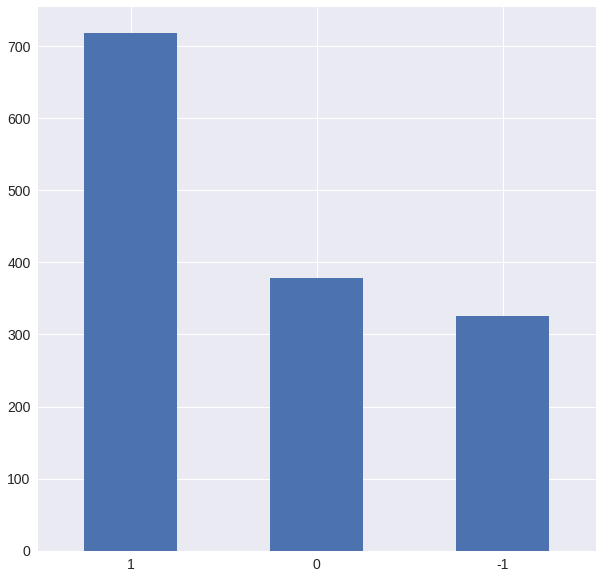

In [3]:
df["home_win"].value_counts().plot.bar(rot=0, figsize=(10,10), fontsize=14)

In [4]:
# O estudo se concentrará nos casos onde o time da casa venceu. Portanto será feito o split no dataset
# para trabalhar com os 718 casos.

df = df[df["home_win"] == 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 1421
Columns: 102 entries, AG to ycards_home_2nd_season
dtypes: float64(11), int64(89), object(2)
memory usage: 577.8+ KB


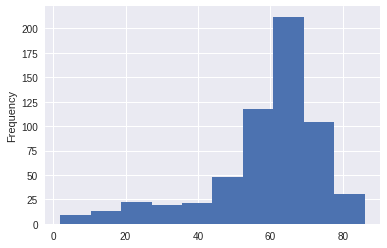

In [5]:
df_filtered = df[df["h_substitution_0_time"] != 0]
df_filtered["h_substitution_0_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

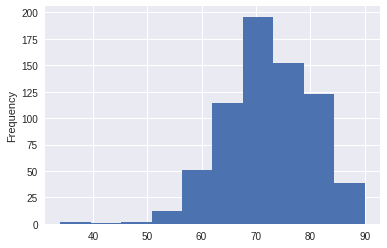

In [6]:
df_filtered = df[df["h_substitution_1_time"] != 0]
df_filtered["h_substitution_1_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

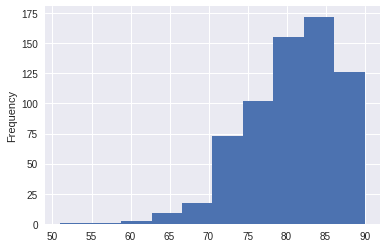

In [7]:
df_filtered = df[df["h_substitution_2_time"] != 0]
df_filtered["h_substitution_2_time"].apply(lambda x : 45 if x == 'INTERVALO' else int(x)).plot.hist()

In [8]:
from sklearn.model_selection import train_test_split

target_columns = [
    'h_substitution_1_interval_0',
    'h_substitution_1_interval_1',
    'h_substitution_1_interval_2',
    'h_substitution_2_interval_0',
    'h_substitution_2_interval_1',
    'h_substitution_2_interval_2'
]

Y = df.filter(target_columns, axis=1)
try:
    X = df.drop(columns=target_columns, axis=1, inplace=True)
except:
    pass
df = df.drop(df.filter(regex=r'(h_substitution_[1,2])').columns, axis=1)
exclude = ['away_team_name', 'home_team_name', 'date', 'y_0_effectiveness', 'y_1_effectiveness', 'y_2_effectiveness']
X = df.drop(columns=exclude, axis='columns')

## Model selection (Kfold)

In [9]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import KFold

kf = KFold(n_splits=2, random_state=None, shuffle=True)

# Transformar o Y em uma dimensão (Multiclasse):
Y_mclass = pd.DataFrame(LabelPowerset().transform(Y))

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_m, y_test_m = Y.iloc[train_index], Y.iloc[test_index]
    y_train, y_test = Y_mclass.iloc[train_index], Y_mclass.iloc[test_index]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 0 to 1421
Data columns (total 74 columns):
AG                                    718 non-null int64
AvgA                                  718 non-null float64
AvgD                                  718 non-null float64
AvgH                                  718 non-null float64
HG                                    718 non-null int64
MaxA                                  718 non-null float64
MaxD                                  718 non-null float64
MaxH                                  718 non-null float64
PA                                    718 non-null float64
PD                                    718 non-null float64
PH                                    718 non-null float64
a_substitution_0_interval_0           718 non-null int64
a_substitution_0_interval_1           718 non-null int64
a_substitution_0_interval_2           718 non-null int64
a_substitution_0_is_home              718 non-null int64
a_substitution_0_numb

In [44]:
y_train

,0
0,0
3,1
8,1
9,1
12,1
13,1
14,1
15,1
19,1
22,1


## Visualização da distribuição do target (y_train)

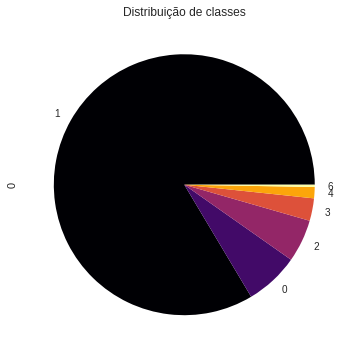

In [12]:
target_view = pd.DataFrame(y_train)
target_view[0].value_counts().plot(kind='pie', figsize=(12,6), title='Distribuição de classes', colormap='inferno')

# Feature selection

In [26]:
# Links úteis http://minerandodados.com.br/index.php/2018/05/21/feature-selection-bala-de-prata/

PERCENTILE = 75

from skmultilearn.problem_transform import LabelPowerset
from sklearn.feature_selection import SelectPercentile, f_classif

fs = SelectPercentile(f_classif, percentile=PERCENTILE)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
x = pd.DataFrame(X_train_fs)
x.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [14 25 33 36 61] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.0,4.14,3.30,1.89,1.0,5.30,3.44,2.02,4.22,3.41,...,0.0,71.0,0.92,0.0,1.0,0.0,1.0,6.0,3.0,5.0
1,0.0,4.82,3.37,1.76,2.0,6.00,3.58,1.82,5.30,3.58,...,0.0,67.0,1.03,0.0,0.0,0.0,1.0,2.0,0.0,0.0
2,1.0,6.42,3.92,1.51,3.0,7.70,4.31,1.60,7.47,4.23,...,0.0,49.0,1.14,0.0,0.0,0.0,1.0,2.0,2.0,4.0
3,0.0,3.37,3.18,2.16,3.0,3.74,3.36,2.31,3.74,3.31,...,0.0,58.0,0.79,0.0,1.0,0.0,0.0,2.0,0.0,1.0
4,1.0,3.31,3.26,2.17,2.0,3.90,3.45,2.30,3.52,3.45,...,0.0,64.0,0.66,0.0,0.0,0.0,2.0,3.0,0.0,2.0


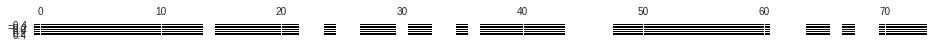

In [27]:
mask = fs.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

# Implementação e avaliação dos Classificadores

In [28]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

rf_params = {
    "criterion": ['entropy', 'gini'],
    "n_estimators": [25, 50, 75],
    "bootstrap": [False, True],
    "max_depth": [3, 5, 10, 15, 20, 50, 90],
    #"max_features": ['auto', 0.1, 0.2, 0.3, 0.10]
}

knn_params = {
    "algorithm": ['ball_tree', 'kd_tree', 'brute'],
    #"n_neighbors": [3, 5, 11, 19],
    #"weights": ['uniform', 'distance'],
}


svm_params = {
    'kernel': ['rbf', 'linear'],
    'gamma': [1e-3, 1e-4]
    #'C': [1, 100]
}

models = [
    ('Random Forest Classifier', RandomForestClassifier(), rf_params),
    #('KNeighbors Classifier', KNeighborsClassifier(), knn_params),
    #('SVM Classifier', SVC(), svm_params)
]

Random Forest Classifier performance: 



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7994428969359332
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.25      0.03      0.06        32
           2       0.89      0.99      0.94       317
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.91      1.00      0.95       327

   micro avg       0.90      0.95      0.92       677
   macro avg       0.34      0.34      0.32       677
weighted avg       0.87      0.95      0.90       677
 samples avg       0.90      0.94      0.91       677



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


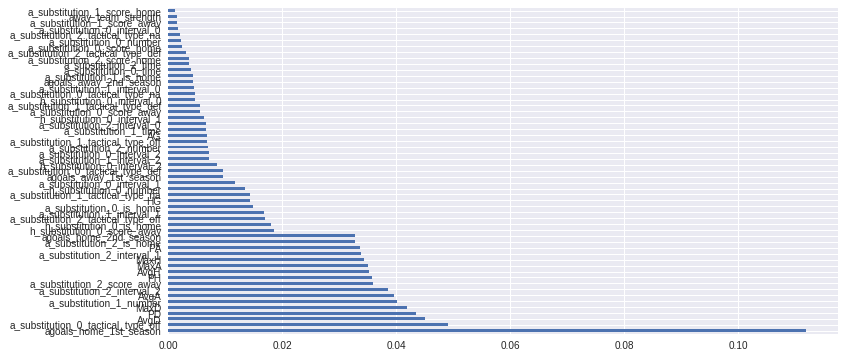

In [31]:
for name, classifier, params in models:
    print ("{} performance: \n".format(name))
    grid_search = GridSearchCV(classifier, param_grid=params, scoring='accuracy', cv=5)
    best_model = LabelPowerset(grid_search, require_dense=[False, True]).fit(X_train_fs, y_train_m)
    y_hat = best_model.predict(X_test_fs)
    
    # Plotar as features mais importantes
    try:
        fsize = len(grid_search.best_estimator_.feature_importances_)
        (pd.Series(grid_search.best_estimator_.feature_importances_, index=X.columns[0:fsize]).nlargest(fsize).plot(kind='barh', figsize=(12,6)))
    except:
        print("Não foi possível extrair as melhores features do classificador {}".format(classifier))
        pass

    print (accuracy_score(y_test_m, y_hat))
    print (classification_report(y_test_m, y_hat))

,0
1,0
2,1
4,1
5,1
6,2
7,1
10,2
11,1
16,1
17,1
